In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data/output_data.csv')
data['price_diff'] = data['output_own_price'] - data['output_comp_price']
data['total_sales'] = data['output_own_sales'] / data['output_own_share']

months_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}
data['index_month'] = data['output_date'].apply(lambda x: x[2:5]).map(months_map).astype(int)
data['index_day'] = data['output_date'].apply(lambda x: x[0:2]).astype(int)

num_cols = data.select_dtypes(include='number')

In [4]:
data

,mkt_id,output_date,output_own_price,output_own_cost,output_comp_price,output_own_profits,output_X,output_own_share,output_own_sales,price_diff,total_sales,index_month,index_day
0,44,01jan2019,7.05,5.90,7.11,15.065000,42.80,0.515267,13.10,-0.06,25.423698,1,1
1,44,02jan2019,7.05,6.05,7.11,24.310000,36.14,0.557082,24.31,-0.06,43.638108,1,2
2,44,03jan2019,7.05,5.98,7.28,30.783910,34.34,0.579922,28.77,-0.23,49.610146,1,3
3,44,04jan2019,7.05,5.98,7.28,20.169500,36.32,0.542767,18.85,-0.23,34.729426,1,4
4,44,05jan2019,6.79,6.07,6.68,1.231200,44.06,0.494757,1.71,0.11,3.456245,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19705,15555,27dec2019,7.28,5.96,7.30,26.070000,36.68,0.515118,19.75,-0.02,38.340759,12,27
19706,15555,28dec2019,6.69,5.94,6.64,3.720000,34.34,0.497312,4.96,0.05,9.973620,12,28
19707,15555,29dec2019,6.69,5.91,6.64,3.393001,32.00,0.424593,4.35,0.05,10.245098,12,29
19708,15555,30dec2019,7.31,5.99,7.42,31.561200,31.10,0.465712,23.91,-0.11,51.340710,12,30


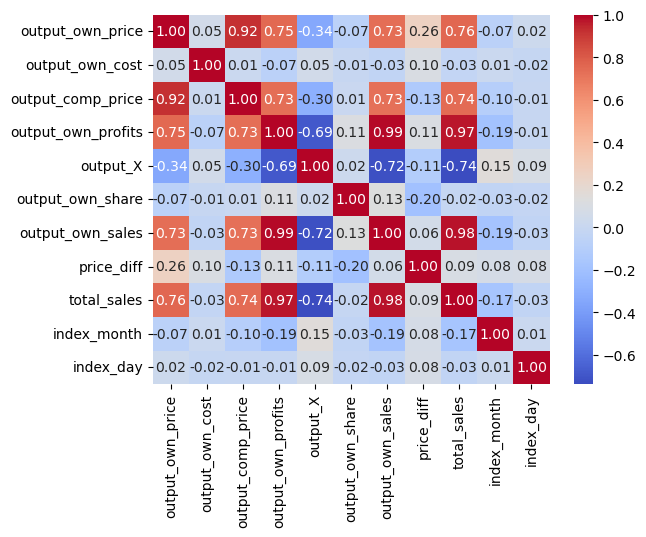

In [5]:
# Calculate correlation matrix
corr_matrix = num_cols.loc[num_cols['mkt_id']==44].corr().drop('mkt_id', axis=1).drop('mkt_id', axis=0)

# Create heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

# Show plot
plt.show()

## Modelling total sales

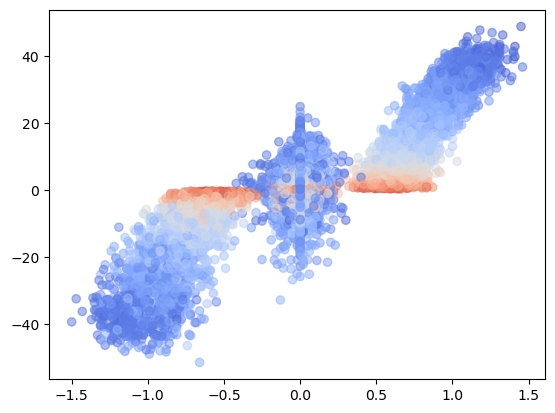

In [6]:
plt.scatter(data['output_own_price'] + data['output_comp_price'] - data['output_own_price'].shift(1) - data['output_comp_price'].shift(1), data['total_sales'] - data['total_sales'].shift(1), c=data['output_X'], cmap='coolwarm', alpha=0.5)

Month 1: 24.62 , 44.24 , 33.93204301075269
Month 2: 30.56 , 48.74 , 36.34452380952381
Month 3: 32.36 , 54.68 , 43.15220430107527
Month 4: 34.16 , 70.88 , 52.414500000000004
Month 5: 36.68 , 74.12 , 56.60970430107527
Month 6: 55.04 , 91.94 , 74.10561110493828
Month 7: 56.48 , 92.84 , 73.59405913978493
Month 8: 55.4 , 83.84 , 70.3220430107527
Month 9: 49.1 , 79.88 , 60.72444444444445
Month 10: 34.34 , 63.5 , 51.747123655913974
Month 11: 32.9 , 56.12 , 41.5135
Month 12: 27.68 , 47.48 , 37.1552688172043


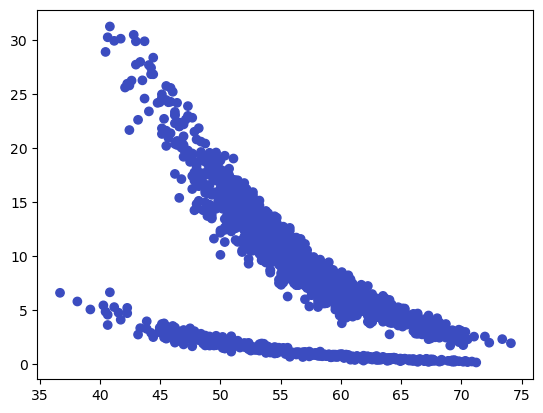

In [7]:
data_for_plot = data.loc[data['index_month']==5]
plt.scatter(data_for_plot['output_X'], data_for_plot['total_sales'], c=data_for_plot['index_month'], cmap='coolwarm')

for i in range(1, 13):
    print(f'Month {i}: {data.loc[data["index_month"]==i]["output_X"].min()} , {data.loc[data["index_month"]==i]["output_X"].max()} , {data.loc[data["index_month"]==i]["output_X"].mean()}')

Text(0, 0.5, 'Market Conditions')

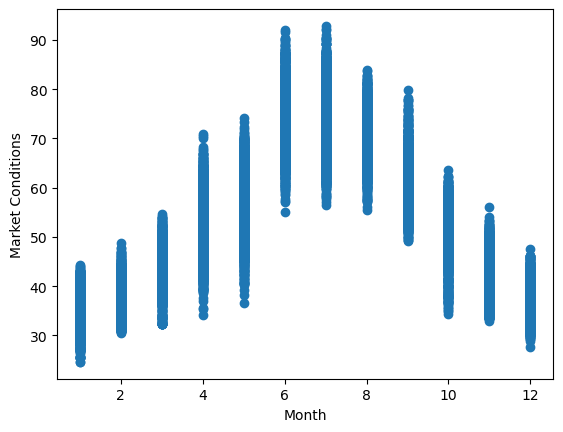

In [8]:
plt.scatter(data['index_month'], data['output_X'])
plt.xlabel('Month')
plt.ylabel('Market Conditions')

Low sales
mkt_id                5256.460215
output_own_price         6.741004
output_own_cost          6.001333
output_comp_price        6.741527
output_own_profits       3.099208
output_X                35.111742
output_own_share         0.499103
output_own_sales         4.187971
price_diff              -0.000523
total_sales              8.375357
index_month              5.844444
index_day               16.088172
dtype: float64
1395
High sales
mkt_id                5321.067101
output_own_price         7.244961
output_own_cost          5.998720
output_comp_price        7.251092
output_own_profits      25.793546
output_X                35.226381
output_own_share         0.500856
output_own_sales        20.613472
price_diff              -0.006131
total_sales             41.148093
index_month              5.428416
index_day               15.305895
dtype: float64
3681


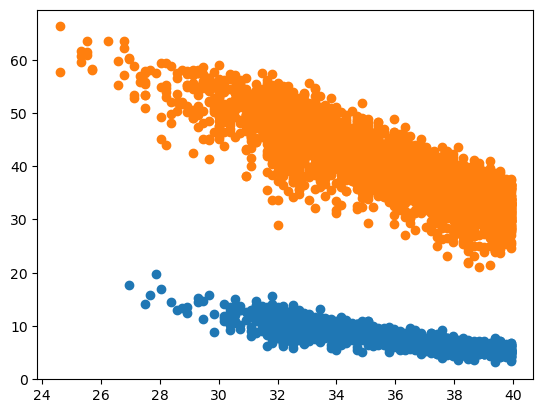

In [9]:
data_1 = num_cols.loc[(num_cols['total_sales']<20) & (num_cols['output_X']<40)]
data_2 = num_cols.loc[(num_cols['total_sales']>20) & (num_cols['output_X']<40)]

print('Low sales')
print(data_1.mean())
print(len(data_1))
plt.scatter(data_1['output_X'], data_1['total_sales'])

print('High sales')
print(data_2.mean())
print(len(data_2))
plt.scatter(data_2['output_X'], data_2['total_sales'])

# MLE on the share of sales (Normal distr) given price difference

0.4997105233345225
-0.17487328960519852


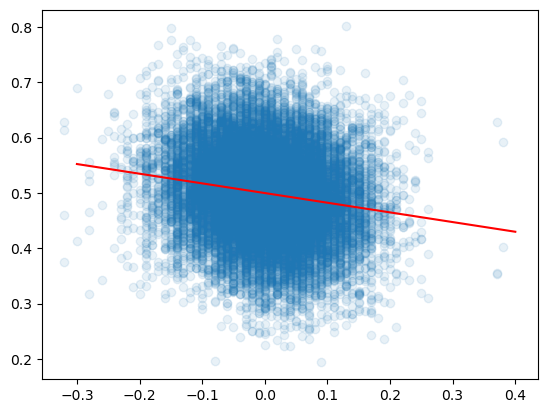

In [10]:
from sklearn.linear_model import LinearRegression

X = data[['price_diff']].copy()
Y = data['output_own_share'].copy()

reg = LinearRegression().fit(X, Y)

print(reg.intercept_)
print(reg.coef_[0])

plt.scatter(X, Y, alpha=0.1)
line = np.linspace(-0.3, 0.4, 100)
plt.plot(line, reg.intercept_ + reg.coef_ * line, 'r')

(array([  3.,   1.,  10.,  10.,  17.,  26.,  33.,  77., 115., 137., 169.,
        141., 107.,  94.,  67.,  30.,  27.,  11.,   4.,   1.]),
 array([0.2257144 , 0.2511422 , 0.27656999, 0.30199779, 0.32742558,
        0.35285338, 0.37828117, 0.40370897, 0.42913676, 0.45456456,
        0.47999235, 0.50542014, 0.53084794, 0.55627574, 0.58170353,
        0.60713132, 0.63255912, 0.65798692, 0.68341471, 0.70884251,
        0.7342703 ]),
 <BarContainer object of 20 artists>)

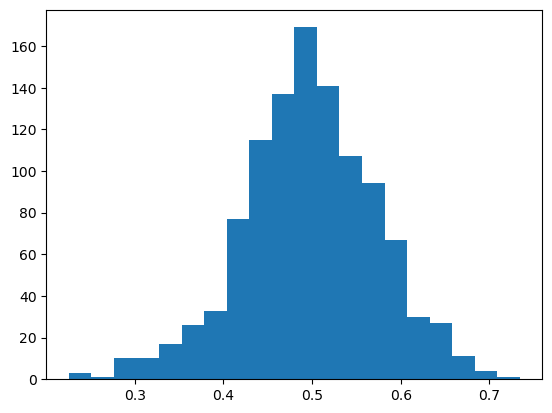

In [11]:
plt.hist(data.loc[(data['price_diff']==0)]['output_own_share'], bins=20)

In [32]:
def log_likelihood(params):
    mu = 1/ (1 + np.exp(-( params[0] + params[1] * data['price_diff'])))
    sigma = params[2]
    n = len(data)
    ll = n/2 * np.log(sigma**2 * 2 * np.pi) + 1/ (2 * sigma**2) * sum((data['output_own_share'] - mu)**2)
    return ll

In [33]:
import scipy.optimize as opt

params_init = np.array([0.5, -0.2, 0.08])
results_mle = opt.minimize(log_likelihood, params_init)

In [34]:
results_mle.x

array([-0.00116298, -0.700296  ,  0.07683602])

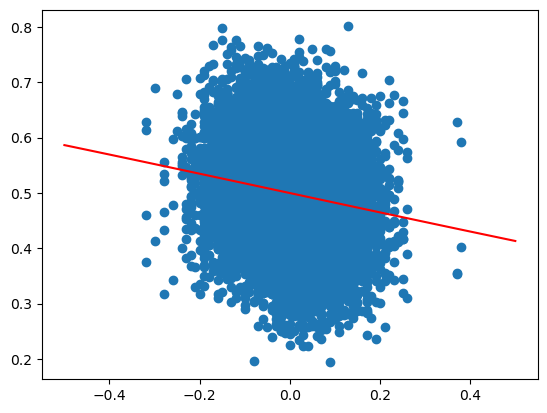

In [25]:
plt.scatter(X, Y)
line = np.linspace(-0.5, 0.5, 100)
plt.plot(line, 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[1] * line))), 'r')

In [55]:
def share_profit(params, c=6, p2=11):
    p1 = params[0]

    mu = 1/(1+np.exp(-(results_mle.x[0] + results_mle.x[1] * (p1 - p2))))
    print(mu)
    mumu = mu / (1 - mu)
    
    return - mumu * (p1 - c)/(mumu * (p1 - c) + p2 - c)

In [61]:
try_cost = 6
try_p2 = 10
cons = ({'type': 'ineq', 'fun': lambda x:  x - try_cost})

params_init = np.array([7])
results = opt.minimize(share_profit, params_init, constraints=cons, args=(try_cost, try_p2))

print(results.x, results.fun)

0.890876449348091
0.8908764483336244
0.8862910399906232
0.8862910389389693
0.8677358063708949
0.8677358051732403
0.8607561679631135
0.8607561667123999
0.8583679681075354
0.8583679668389
[7.42542655] -0.6835159723467109


# Estimating competitor price : Neural Network

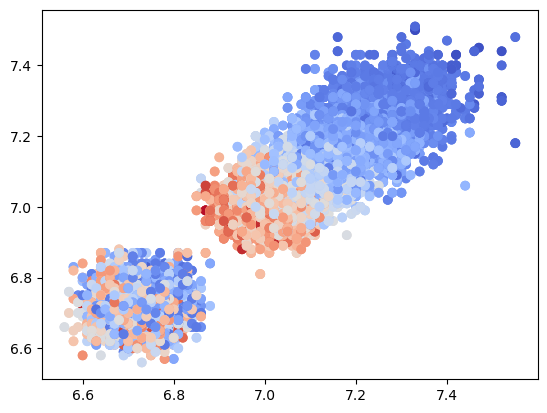

In [19]:
plt.scatter(data['output_own_price'], data['output_comp_price'], c=data['output_X'], cmap='coolwarm')

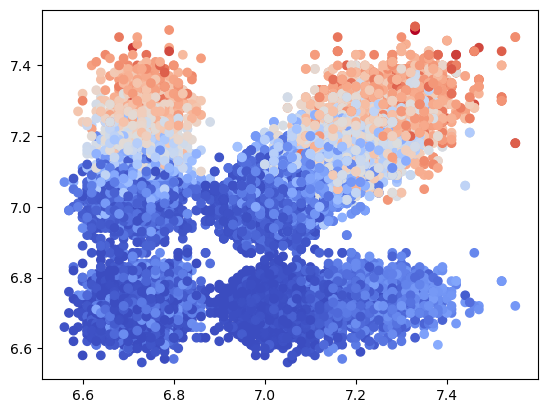

In [20]:
plt.scatter(data['output_own_price'].shift(1), data['output_comp_price'], c=data['total_sales'], cmap='coolwarm')

(array([6.000e+00, 2.000e+00, 2.400e+01, 9.100e+01, 2.030e+02, 9.710e+02,
        1.369e+03, 2.086e+03, 2.829e+03, 3.072e+03, 4.339e+03, 2.128e+03,
        1.330e+03, 7.360e+02, 3.210e+02, 1.720e+02, 2.100e+01, 6.000e+00,
        2.000e+00, 2.000e+00]),
 array([5.79 , 5.812, 5.834, 5.856, 5.878, 5.9  , 5.922, 5.944, 5.966,
        5.988, 6.01 , 6.032, 6.054, 6.076, 6.098, 6.12 , 6.142, 6.164,
        6.186, 6.208, 6.23 ]),
 <BarContainer object of 20 artists>)

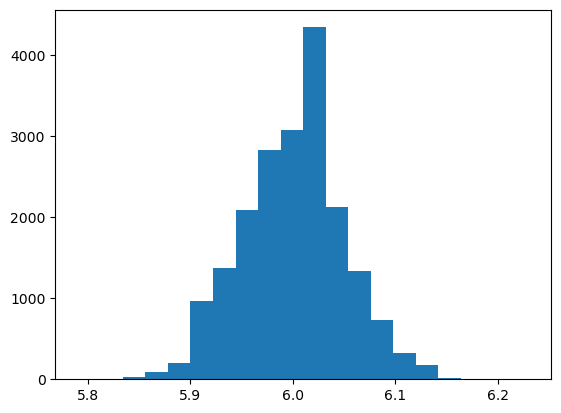

In [21]:
plt.hist(data['output_own_cost'], bins=20)